# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
from idlelib.pyparse import trans
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

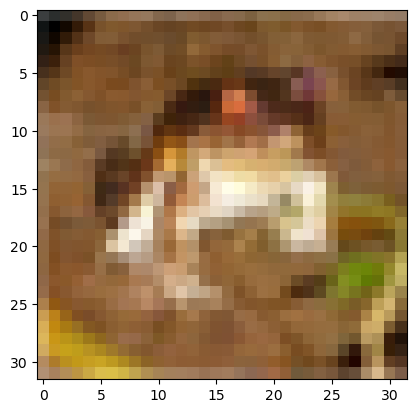

In [2]:
# data loading
cifar_sample = np.load("resources/cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = K $

$ \hspace{140px} H_o = \left\lfloor \frac{H_i + 2P - F}{S} \right\rfloor + 1 $

$ \hspace{140px} W_o = \left\lfloor \frac{W_i + 2P - F}{S} \right\rfloor + 1 $

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   

$ C_f \cdot F \cdot F \cdot K + K$


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="https://raw.githubusercontent.com/gmum/ml2022-23/main/lab/resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [3]:
def get_padded_image(image: torch.tensor, padding: int):
    img_channels, img_height, img_width = image.shape
    padded_image = torch.zeros((img_channels, img_height + 2 * padding, img_width + 2 * padding))
    padded_image[:, padding:img_height + padding, padding:img_height + padding] = image
    return padded_image

In [4]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = (img_height + 2 * padding - filter_size) // stride + 1
    out_width = (img_width + 2 * padding - filter_size) // stride + 1
    out_channels = n_filters

    output = torch.zeros((out_channels, out_height, out_width))
    padded_image = get_padded_image(image, padding)

    for n_filter in range(n_filters):
        output[n_filter, :, :] = bias[n_filter]
        for c in range(img_channels):
            for out_h, h in enumerate(range(0, img_height + 2 * padding - filter_size + 1, stride)):
                for out_w, w in enumerate(range(0, img_width + 2 * padding - filter_size + 1, stride)):
                    filter_product = (
                            padded_image[c, h:h + filter_size, w:w + filter_size] * filters[n_filter, c]).sum()
                    output[n_filter, out_h, out_w] += filter_product
    return output

In [5]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [6]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = (img_height + 2 * padding - kernel_size) // stride + 1
    out_width = (img_width + 2 * padding - kernel_size) // stride + 1
    out_channels = img_channels

    output_img = torch.zeros((out_channels, out_height, out_width))
    padded_image = get_padded_image(image, padding)

    for c in range(img_channels):
        for out_h, h in enumerate(range(0, img_height + 2 * padding - kernel_size + 1, stride)):
            for out_w, w in enumerate(range(0, img_width + 2 * padding - kernel_size + 1, stride)):
                output_img[c, out_h, out_w] = padded_image[c, h:h + kernel_size, w:w + kernel_size].max()
    return output_img

In [7]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


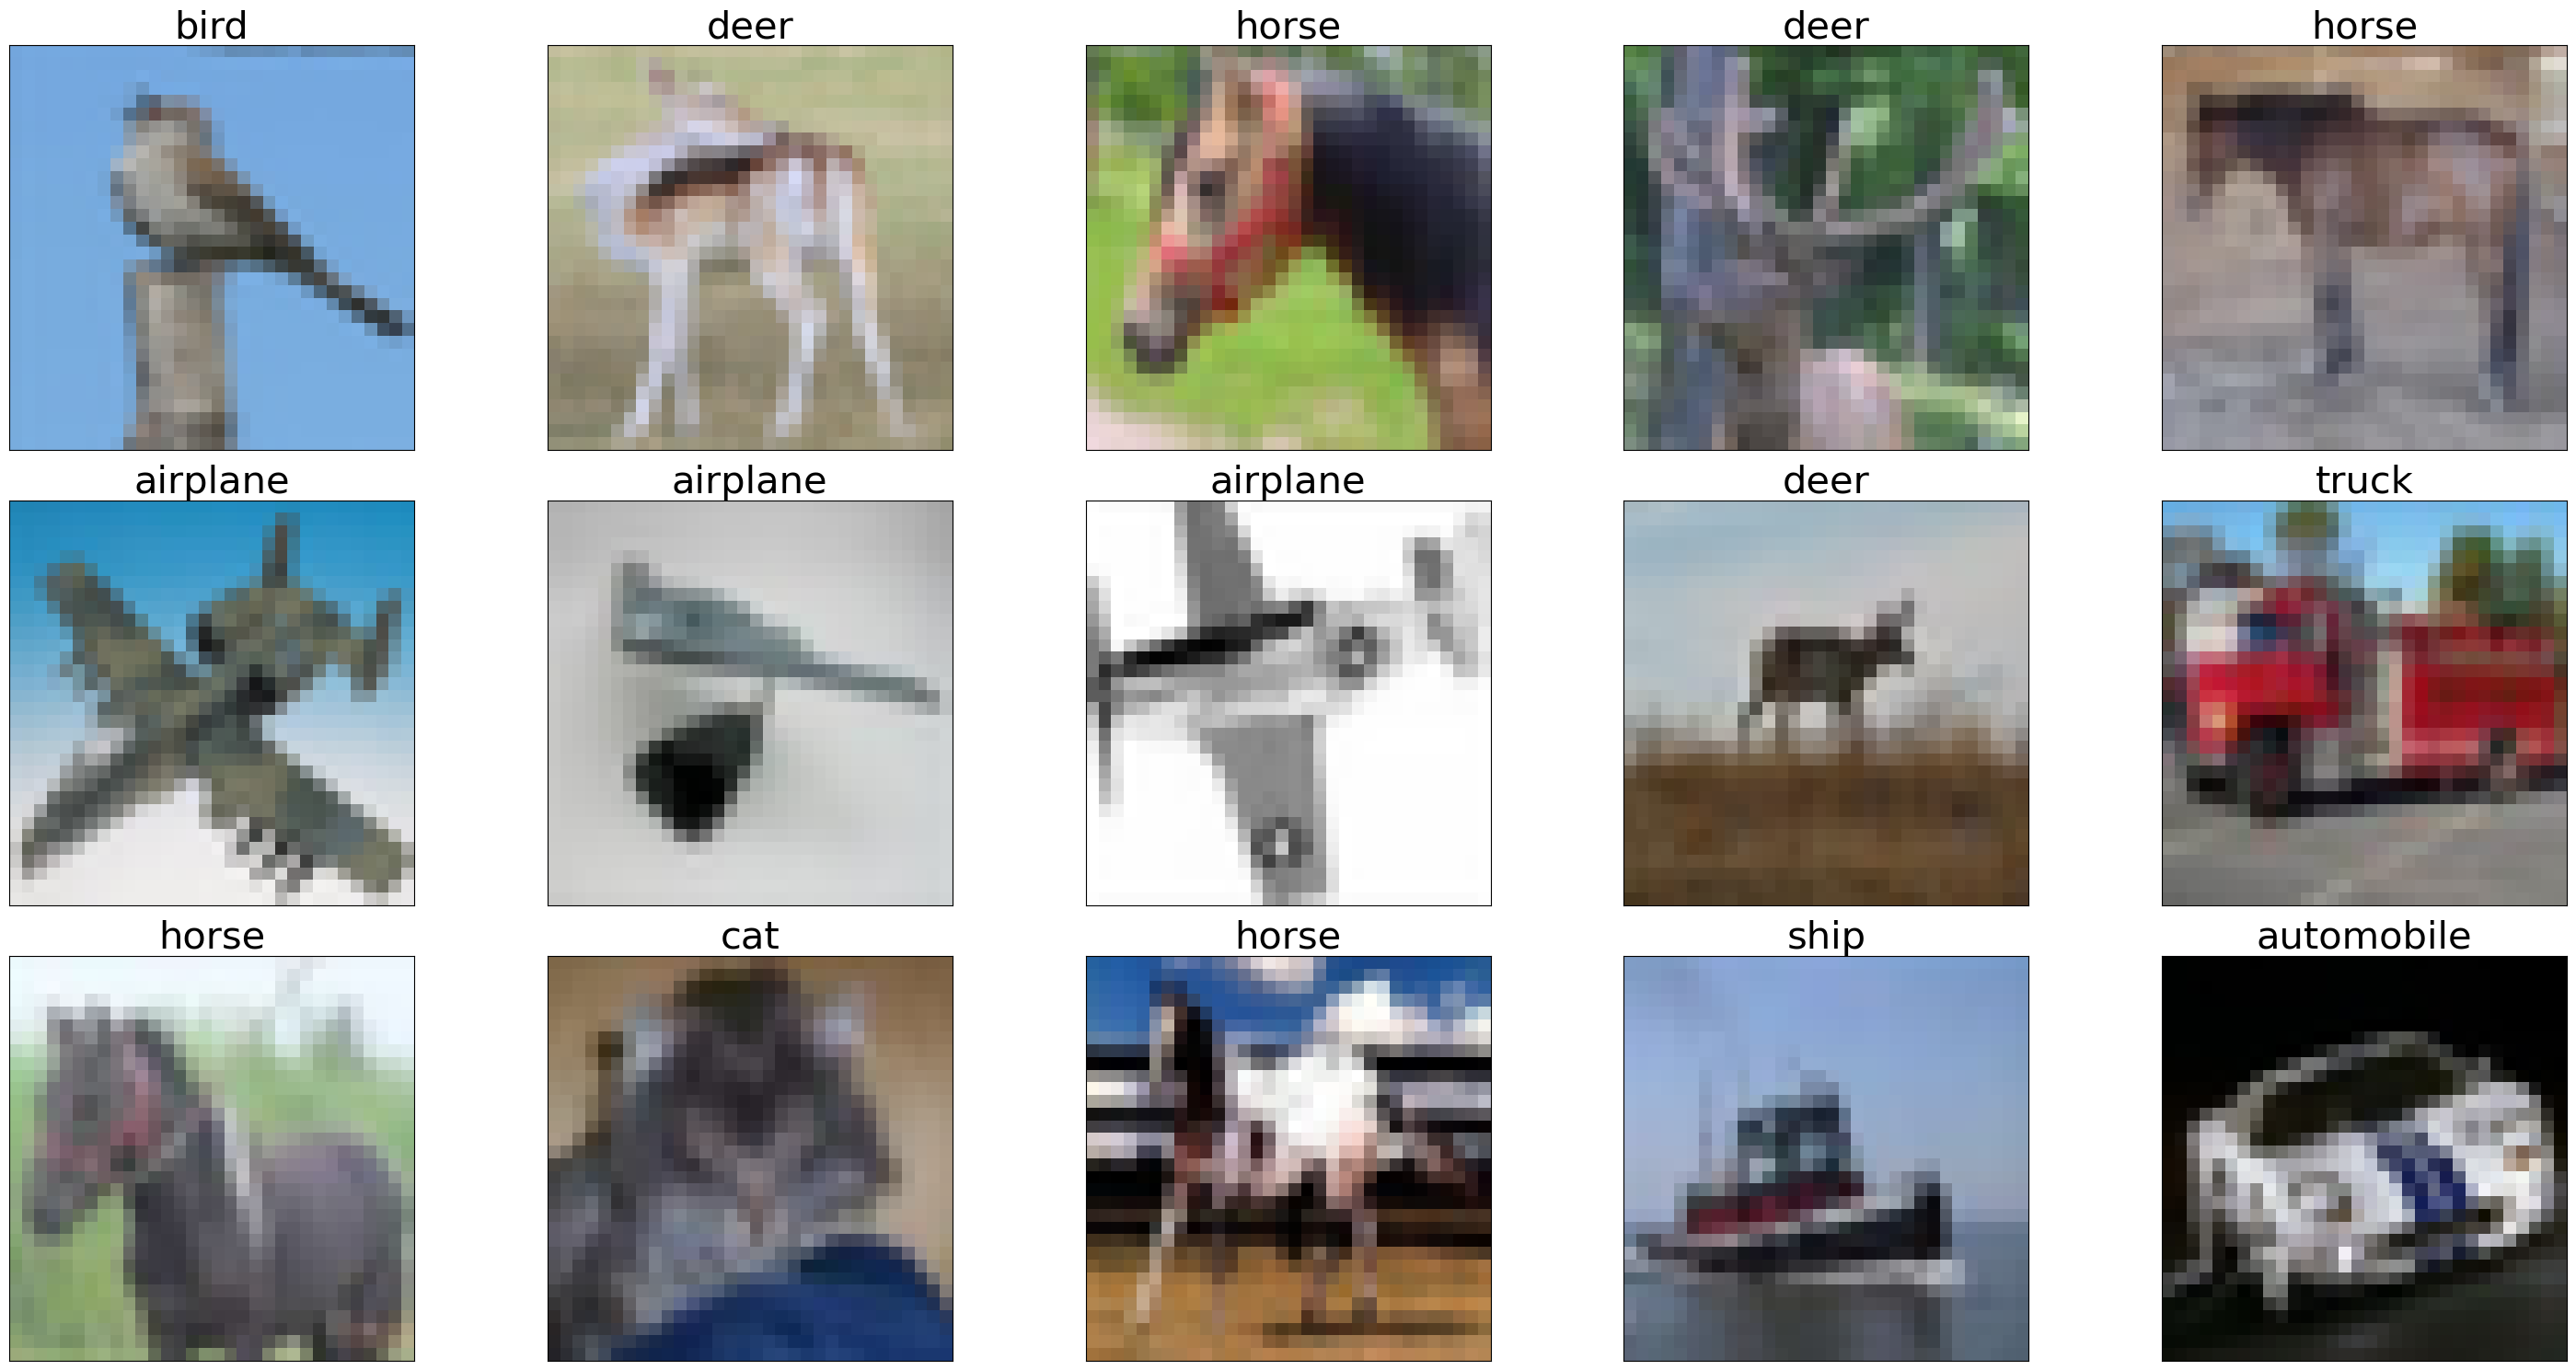

In [9]:
dataset = CIFAR10(root="./data", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [10]:
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [22]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_loss: list, test_loss: list, test_accuracy: list, epochs: int = None):
    if epochs is None:
        epochs = len(train_loss)

    x = range(1, epochs + 1)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(x, train_loss, label="Train Loss", color='blue', linestyle='-', linewidth=2)
    ax[0].plot(x, test_loss, label="Test Loss", color='orange', linestyle='--', linewidth=2)
    ax[0].set_title("Loss over Epochs", fontsize=16)
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Loss", fontsize=14)
    ax[0].legend(fontsize=12)
    ax[0].grid(True)

    ax[1].plot(x, test_accuracy, label="Test Accuracy", color='green', linestyle='-', linewidth=2, marker='o')
    ax[1].set_title("Accuracy over Epochs", fontsize=16)
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Accuracy (%)", fontsize=14)
    ax[1].legend(fontsize=12)
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data',
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='./data',
                       train=False,
                       download=True,
                       transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
def model_train(model: nn.Module, train_loader: DataLoader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    num_batches = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()

        if (i + 1) % 2000 == 0:
            print(f"\tBatch {i + 1}/{num_batches}, Loss: {running_loss / 2000:.4f}")
            running_loss = 0.0

    avg_loss = total_loss / len(train_loader)
    print(f"\tAverage Loss: {avg_loss:.4f}")
    return avg_loss

In [17]:
def model_test(model: nn.Module, test_loader: DataLoader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / total
    print(f"\n\tTest Results:")
    print(f"\tAccuracy: {accuracy:.2f}%")
    print(f"\tAverage Loss: {avg_loss:.4f}\n")
    return avg_loss, accuracy


In [18]:
epochs = 20
train_losses = []
test_losses = []
accuracy_over_time = []

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = model_train(net, train_loader, criterion, optimizer)
    test_loss, accuracy = model_test(net, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_over_time.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
	Batch 2000/12500, Loss: 1.9451
	Batch 4000/12500, Loss: 1.7004
	Batch 6000/12500, Loss: 1.6161
	Batch 8000/12500, Loss: 1.5432
	Batch 10000/12500, Loss: 1.4774
	Batch 12000/12500, Loss: 1.4196
	Average Loss: 1.6099

	Test Results:
	Accuracy: 54.84%
	Average Loss: 1.2491

Epoch 2
-------------------------------
	Batch 2000/12500, Loss: 1.3528
	Batch 4000/12500, Loss: 1.3034
	Batch 6000/12500, Loss: 1.2637
	Batch 8000/12500, Loss: 1.2451
	Batch 10000/12500, Loss: 1.2321
	Batch 12000/12500, Loss: 1.1913
	Average Loss: 1.2623

	Test Results:
	Accuracy: 63.60%
	Average Loss: 1.0347

Epoch 3
-------------------------------
	Batch 2000/12500, Loss: 1.1256
	Batch 4000/12500, Loss: 1.1392
	Batch 6000/12500, Loss: 1.1250
	Batch 8000/12500, Loss: 1.0661
	Batch 10000/12500, Loss: 1.0687
	Batch 12000/12500, Loss: 1.0751
	Average Loss: 1.0982

	Test Results:
	Accuracy: 67.40%
	Average Loss: 0.9415

Epoch 4
-------------------------------
	Batch 2000/12500, Lo

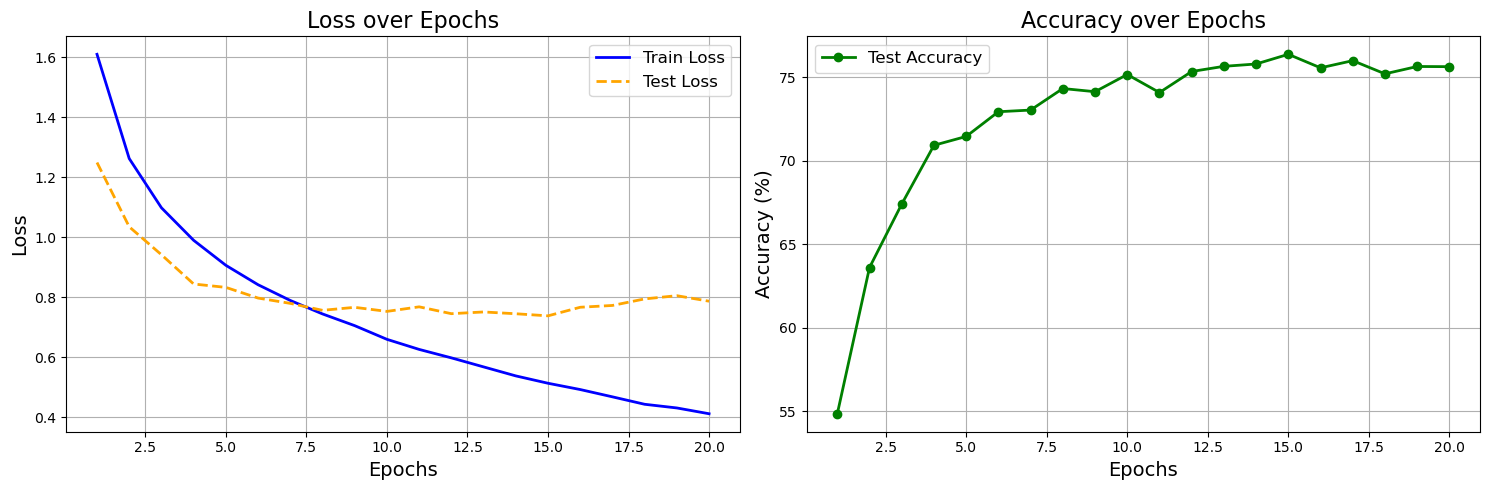

In [23]:
plot_learning_curves(train_losses, test_losses, accuracy_over_time, epochs)

# Augmentacja danych

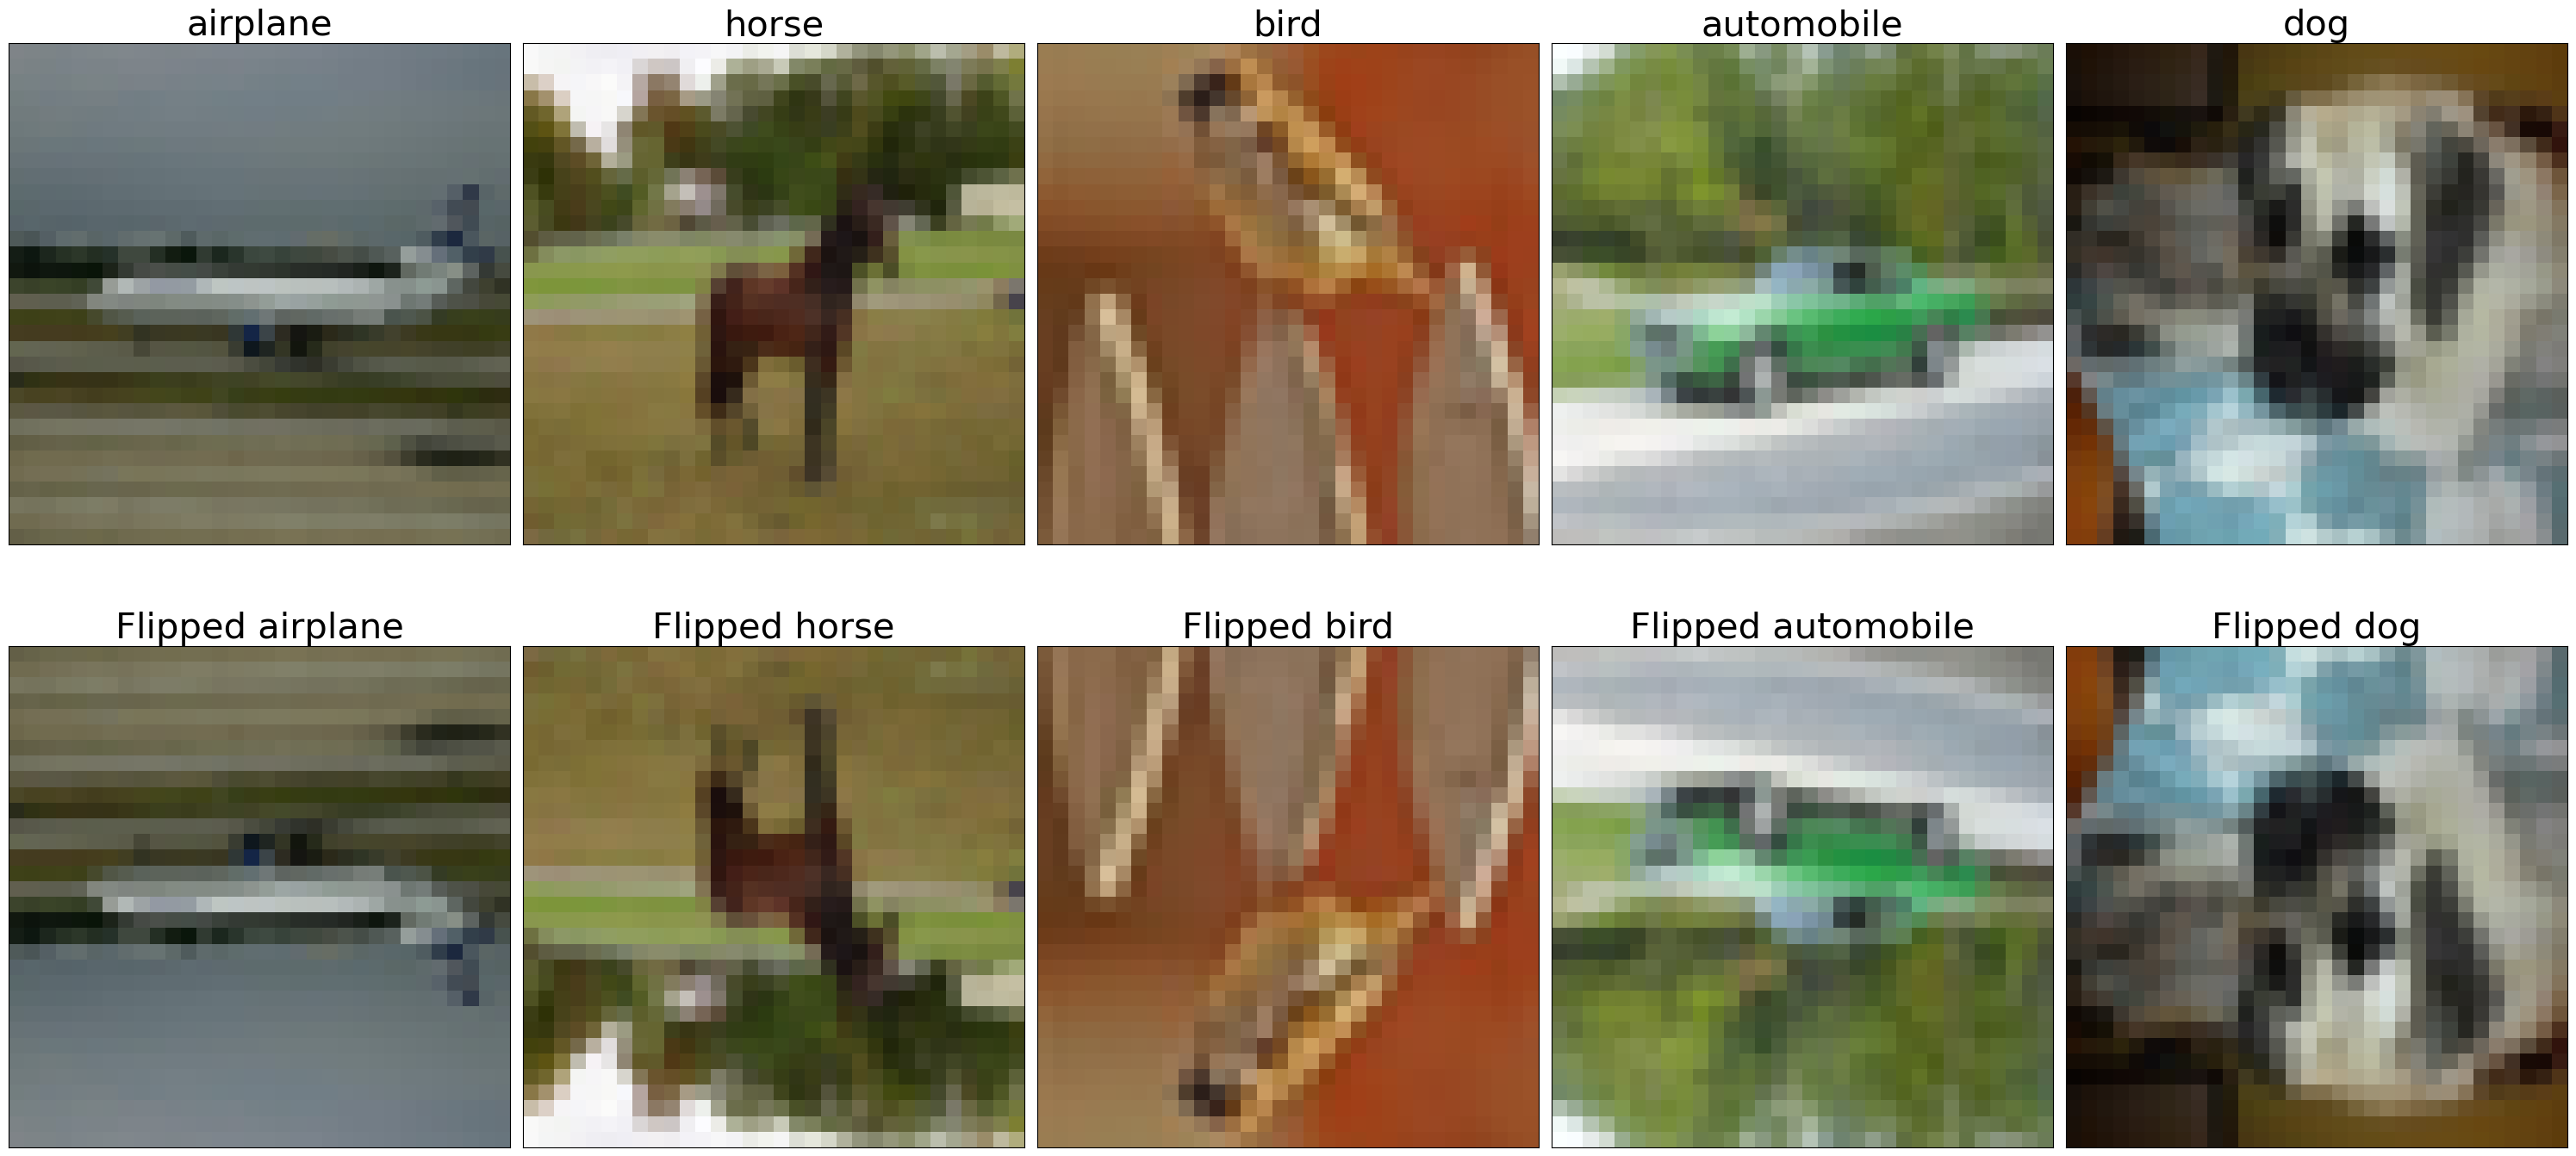

In [20]:
# load test set
dataset = CIFAR10(root="./data", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [47]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter, Compose, \
    RandomResizedCrop, Normalize

_transforms = Compose([
    RandomResizedCrop((32, 32)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.5, hue=0.5),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_train_dataset = CIFAR10(root='./data',
                        train=True,
                        download=True,
                        transform=_transforms)

test_dataset = CIFAR10(root='./data',
                       train=False,
                       download=True,
                       transform=transform)

augmented_train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
augmented_test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
augmented_net = Net().to(device)
augmented_criterion = nn.CrossEntropyLoss()
augmented_optimizer = optim.SGD(augmented_net.parameters(), lr=0.001, momentum=0.9)

In [49]:
epochs = 20
augmented_train_losses = []
augmented_test_losses = []
augmented_accuracy_over_time = []

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = model_train(augmented_net, augmented_train_loader, augmented_criterion, augmented_optimizer)
    test_loss, accuracy = model_test(augmented_net, augmented_test_loader, augmented_criterion)
    augmented_train_losses.append(train_loss)
    augmented_test_losses.append(test_loss)
    augmented_accuracy_over_time.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
	Batch 2000/12500, Loss: 1.9224
	Batch 4000/12500, Loss: 1.7107
	Batch 6000/12500, Loss: 1.6000
	Batch 8000/12500, Loss: 1.5161
	Batch 10000/12500, Loss: 1.4682
	Batch 12000/12500, Loss: 1.4187
	Average Loss: 1.5973

	Test Results:
	Accuracy: 56.34%
	Average Loss: 1.2161

Epoch 2
-------------------------------
	Batch 2000/12500, Loss: 1.3174
	Batch 4000/12500, Loss: 1.3014
	Batch 6000/12500, Loss: 1.2625
	Batch 8000/12500, Loss: 1.2617
	Batch 10000/12500, Loss: 1.2135
	Batch 12000/12500, Loss: 1.1995
	Average Loss: 1.2569

	Test Results:
	Accuracy: 63.07%
	Average Loss: 1.0343

Epoch 3
-------------------------------
	Batch 2000/12500, Loss: 1.1192
	Batch 4000/12500, Loss: 1.1243
	Batch 6000/12500, Loss: 1.0994
	Batch 8000/12500, Loss: 1.0753
	Batch 10000/12500, Loss: 1.0509
	Batch 12000/12500, Loss: 1.0625
	Average Loss: 1.0867

	Test Results:
	Accuracy: 66.50%
	Average Loss: 0.9745

Epoch 4
-------------------------------
	Batch 2000/12500, Lo

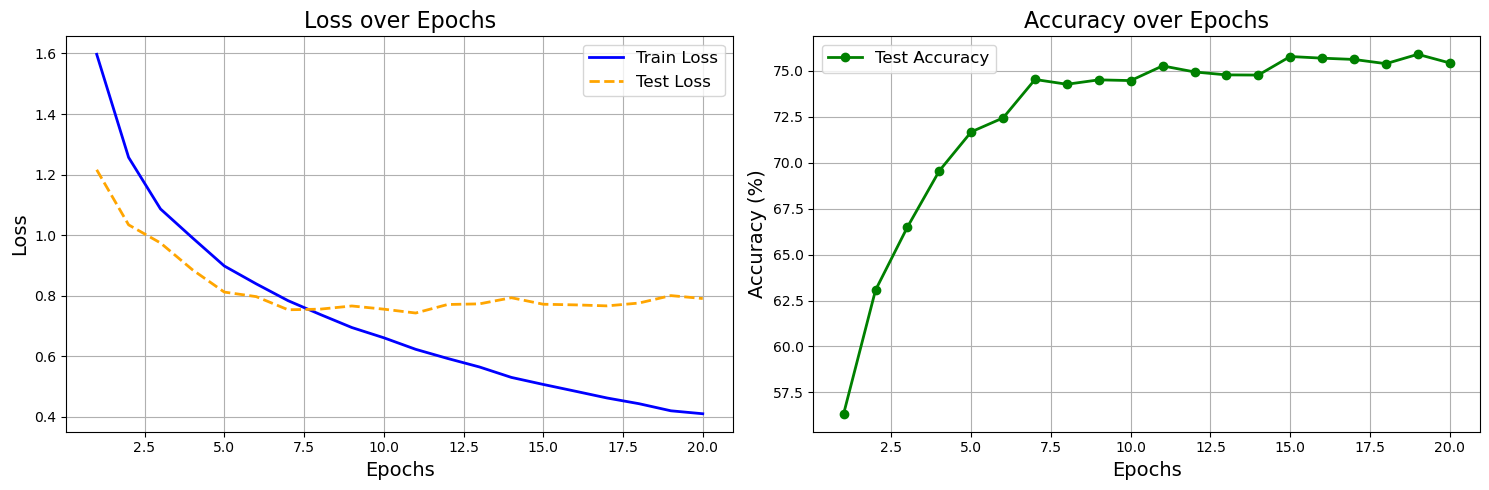

In [50]:
plot_learning_curves(augmented_train_losses, augmented_test_losses, augmented_accuracy_over_time, epochs)

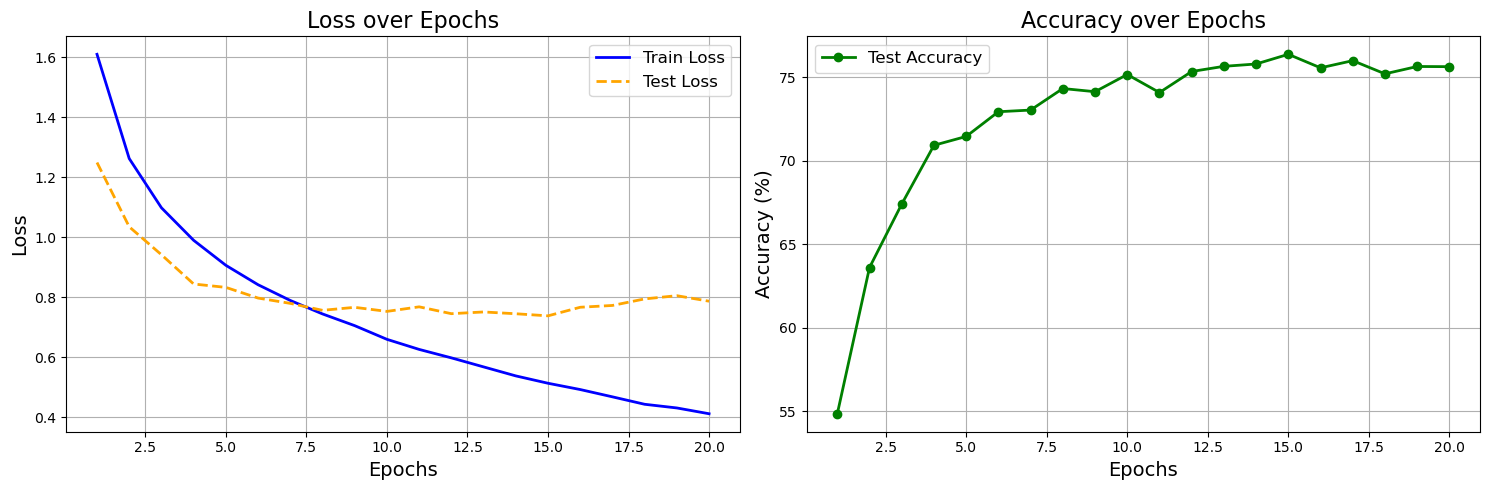

In [51]:
plot_learning_curves(train_losses, test_losses, accuracy_over_time, epochs)

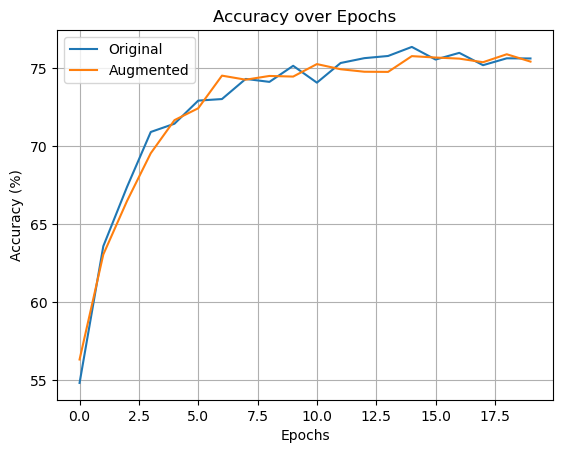

In [52]:
# show the difference
plt.plot(accuracy_over_time, label="Original")
plt.plot(augmented_accuracy_over_time, label="Augmented")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


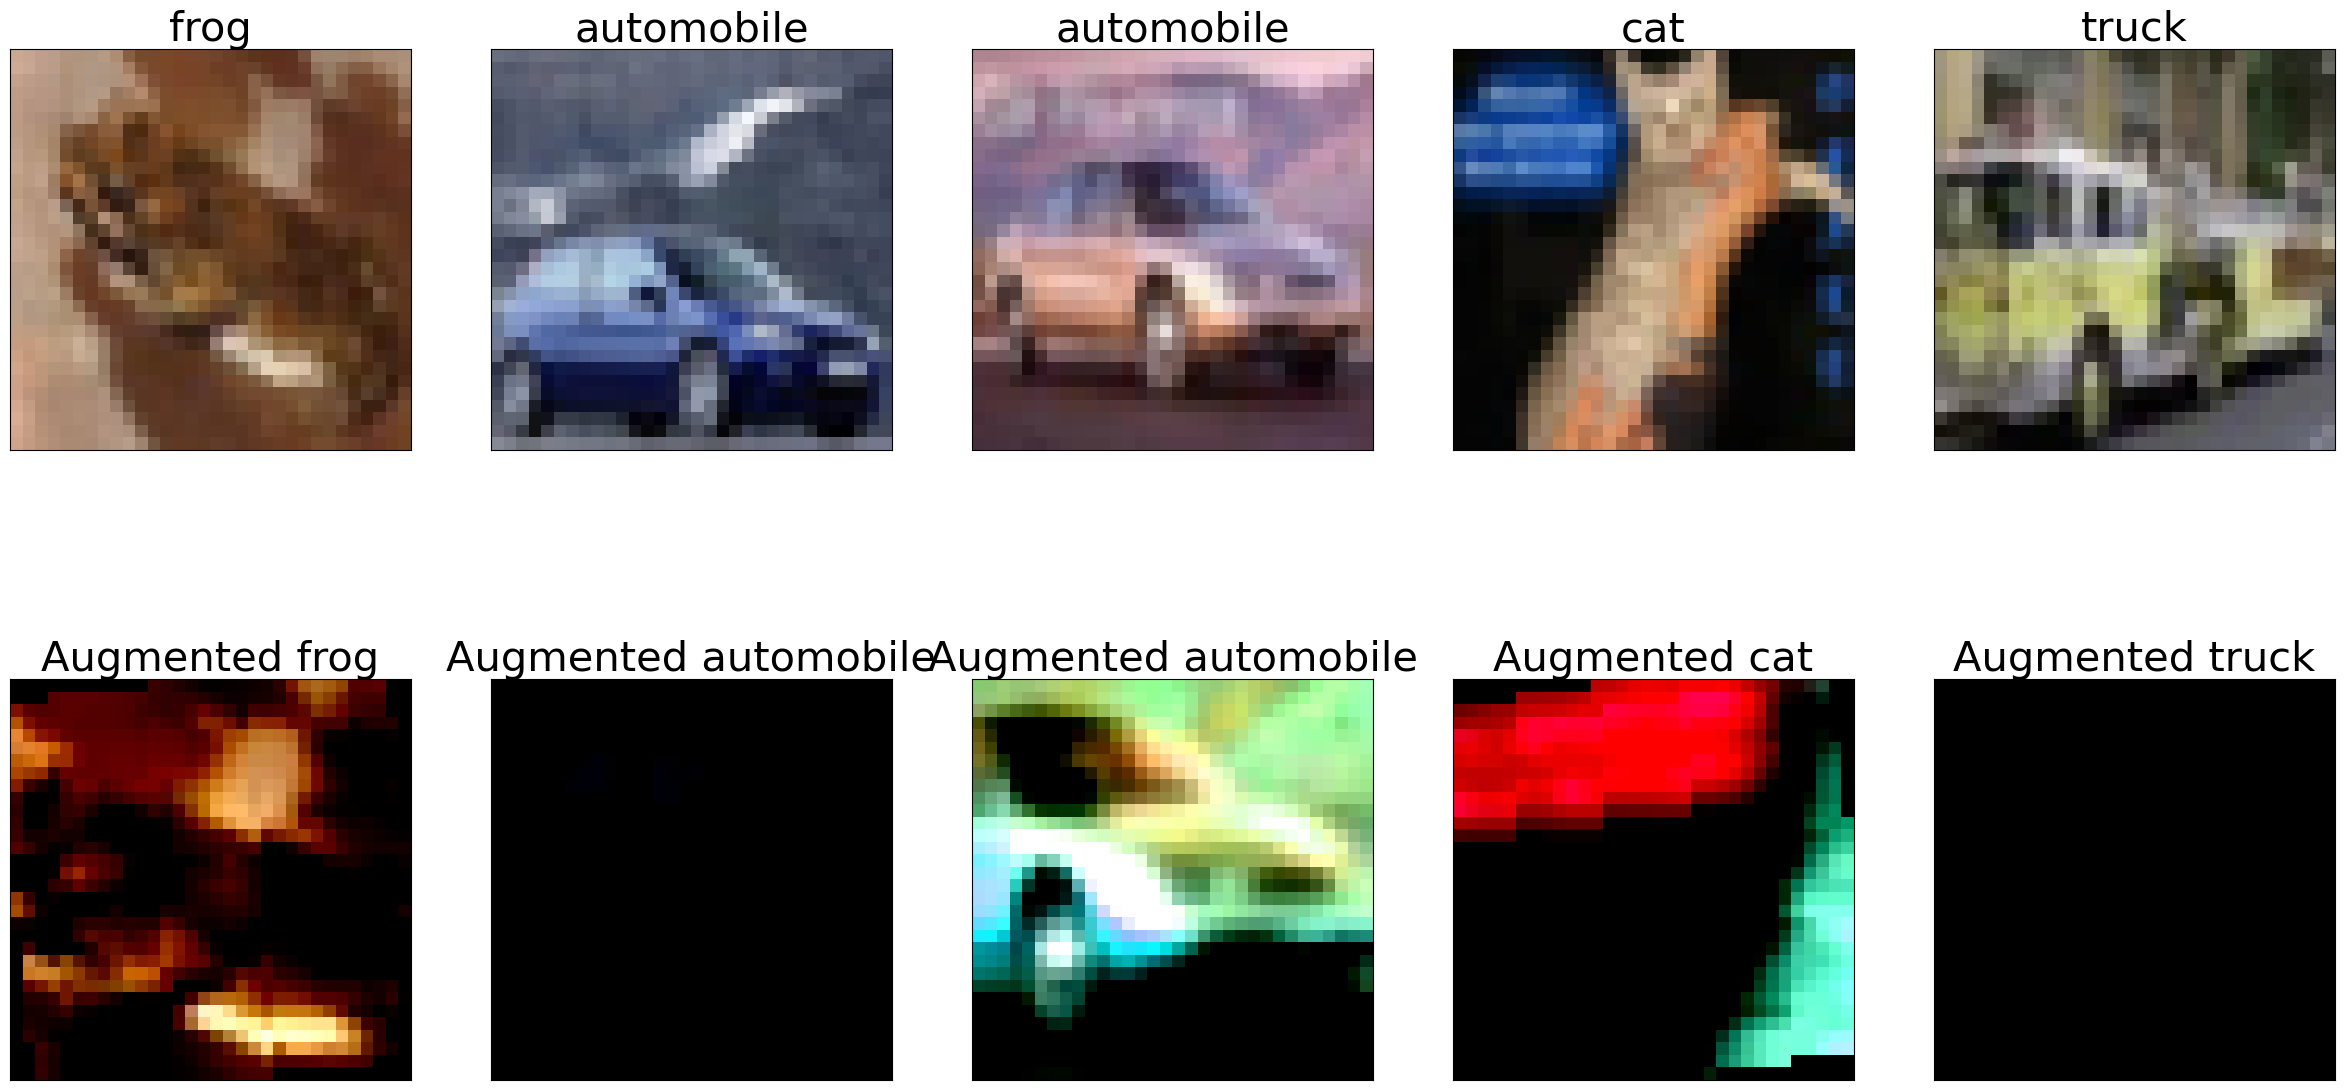

In [54]:
from torchvision.transforms import ToPILImage

# show the difference between augmented and original images

# load some data
for x, y in loader:
    break

# visualise the _transforms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))
to_pil = ToPILImage()

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    pil_img = to_pil(img)
    augmented_img = _transforms(pil_img)
    ax.imshow(np.transpose(augmented_img, (1, 2, 0)))
    ax.set_title(f"Augmented {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])